# Using the model to cluster songs according to their genre

In [40]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import torch
import deeplay as dl
import os
import deeptrack as dt

In [41]:
#Helper functions
def createGenreMap():
    genreMap = {} #key:track id, value:genre

    # Open the CSV file in read mode, NOTE: You have to have the file labels.csv in your directory, its available in drive
    with open('labels.csv', 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        #Skip first row (header row)
        next(csv_reader)
    
        # Iterate through the rows in the CSV file
        for row in csv_reader:
            raw_number = int(row[0])
            track_id = f"{raw_number:06d}"
            genre = row[1]
            genreMap[track_id] = genre

    return genreMap
    
def getLabel(genreMap, track_id):
    #Genre map is dictionary created above, track_id is string id of track.
    track_id_final = f"{track_id:06d}"
    return genreMap[track_id_final]

In [58]:
"""METHOD 1: UMAP"""

def umap_clustering(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: All latent space representations of the tracks, shape (n_tracks, latent_dim)
        reduced_dim: Reduced dimension for UMAP (2 or 3)
        genre_labels: List of genre names corresponding to each track
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    reducer = umap.UMAP(n_components=reduced_dim)
    reduced_proj = reducer.fit_transform(data)

    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    elif reduced_dim == 2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20')
        plt.xlabel("x")
        plt.ylabel("y")
    else:
        print("Please enter 2 or 3 as the reduced_dim")
        return

    # Legend
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)
    cmap = plt.cm.tab20
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in enumerate(genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("UMAP Clustering")
    plt.tight_layout()
    plt.show()

In [ ]:
"""METHOD 2: PCA"""

def pca_clustering(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: Latent representations of tracks, shape (n_tracks, latent_dim)
        reduced_dim: 2 or 3
        genre_labels: List of genre names (strings)
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    # PCA transformation
    pca = PCA(n_components=reduced_dim)
    reduced_proj = pca.fit_transform(data)

    # Plot
    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20')
        ax.set_xlabel("1st principal direction")
        ax.set_ylabel("2nd principal direction")
        ax.set_zlabel("3rd principal direction")
    elif reduced_dim ==2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20')
        plt.xlabel("1st principal direction")
        plt.ylabel("2nd principal direction")
    else:
        print('Please make the reduced_dim 2 or 3')
        return

    # Legend with genre names
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)

    cmap = plt.cm.tab20
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in enumerate(genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("PCA Clustering")
    plt.tight_layout()
    plt.show()

In [44]:
mapping = createGenreMap()

In [45]:
#Get data
track_ids = mapping.keys()
print(f"Track names: {list(track_ids)}")

genre_labels = list(mapping.values())
print(f"Genre corresponding to each track: {genre_labels}")

number_of_tracks = len(track_ids)
genres = set(genre_labels)
num_of_genres = len(genres)

print(f"Number of tracks: {number_of_tracks}")
print(f"Genres: {genres}")
print(f"Number of genres: {num_of_genres}")

Track names: ['000002', '000003', '000005', '000010', '000020', '000026', '000030', '000046', '000048', '000134', '000135', '000136', '000137', '000138', '000139', '000140', '000141', '000142', '000144', '000145', '000146', '000147', '000148', '000149', '000150', '000151', '000152', '000153', '000154', '000155', '000156', '000157', '000158', '000159', '000160', '000161', '000162', '000163', '000164', '000165', '000166', '000167', '000168', '000169', '000170', '000171', '000172', '000173', '000174', '000175', '000176', '000177', '000178', '000179', '000181', '000182', '000183', '000184', '000185', '000188', '000189', '000190', '000191', '000192', '000193', '000194', '000195', '000196', '000197', '000198', '000199', '000200', '000201', '000202', '000203', '000204', '000205', '000206', '000207', '000208', '000209', '000210', '000211', '000212', '000213', '000226', '000228', '000236', '000237', '000238', '000246', '000247', '000248', '000249', '000250', '000251', '000252', '000253', '00025

c:\Users\Lukas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


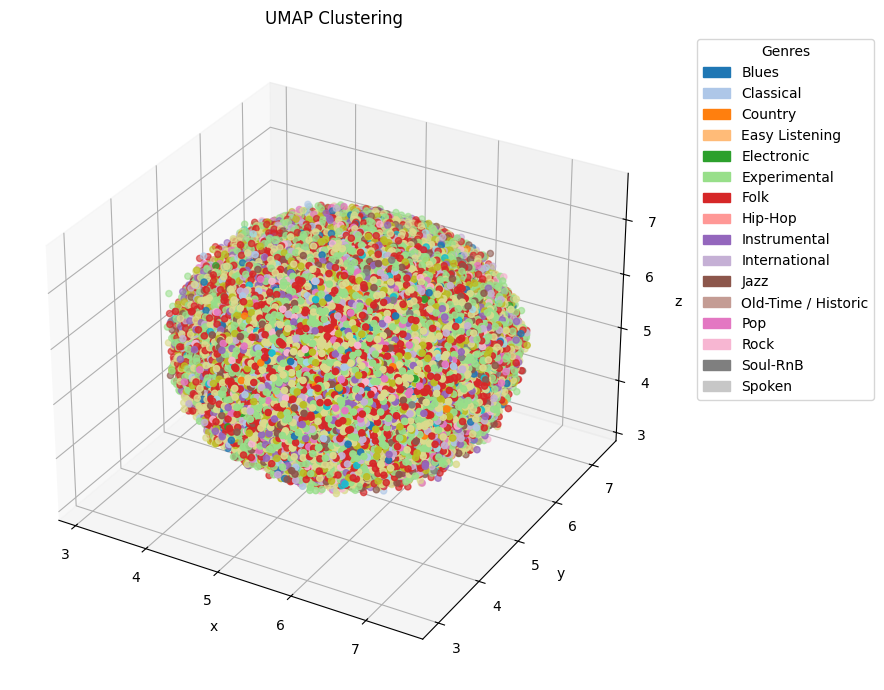

In [46]:
#Example usage of umap
latent_dim = 20
reduced_dim = 3
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

umap_clustering(dummy_data, reduced_dim, genre_labels)

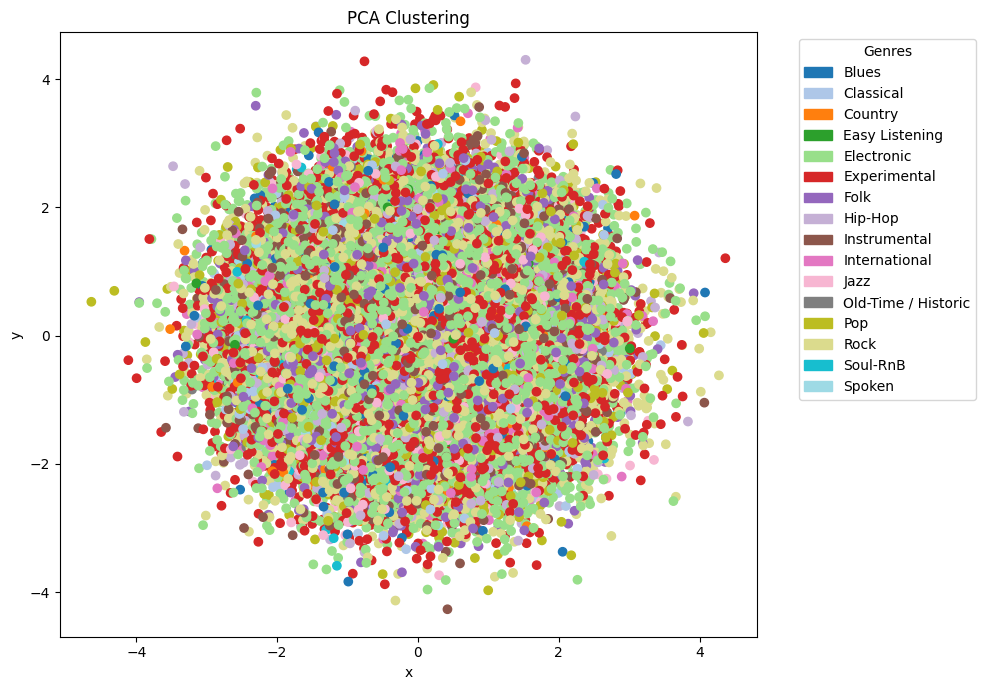

In [47]:
#Example usage of pca

latent_dim = 20
reduced_dim = 2
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

pca_clustering(dummy_data, reduced_dim, genre_labels)

In [48]:
#Try the vae model
vae = dl.VariationalAutoEncoder(input_size=(512,512),
    latent_dim=50, channels=[32, 64, 128],
    reconstruction_loss=torch.nn.MSELoss()
).create()
vae.load_state_dict(torch.load("vaeLowDKL.pth"))
vae.eval()

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
 

In [49]:
#Preprocess data
data_dir = os.path.expanduser("./trainImagesSmall")

# Load image files using ImageFolder
trainFiles = dt.sources.ImageFolder(root=data_dir)
print(f"Number of train images: {len(trainFiles)}")

Number of train images: 1000


In [50]:
#Create image pipeline
class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        # assuming input shape [C, H, W]
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFiles.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512))

In [51]:
#creating a test dataset, it is the same dataset, but added the genre as label as well
label_pip = dt.Value(trainFiles.label_name[:6]) >> int
test_dataset = dt.pytorch.Dataset(image_pip & label_pip, inputs=trainFiles)
test_loader = dl.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [52]:
mu_list, labels = [], []
i = 0
for img, raw_track_id in test_loader:
    track_id = int(raw_track_id[0])
    label = getLabel(mapping, track_id)
    mu, _ = vae.encode(img)
    mu_list.append(mu)
    labels.append(label)
    if i == 300:
        break
    i += 1

In [53]:
mu_array = torch.cat(mu_list, dim=0).detach().numpy()

In [54]:
print(len(labels))
print(mu_array.shape)

301
(301, 50)


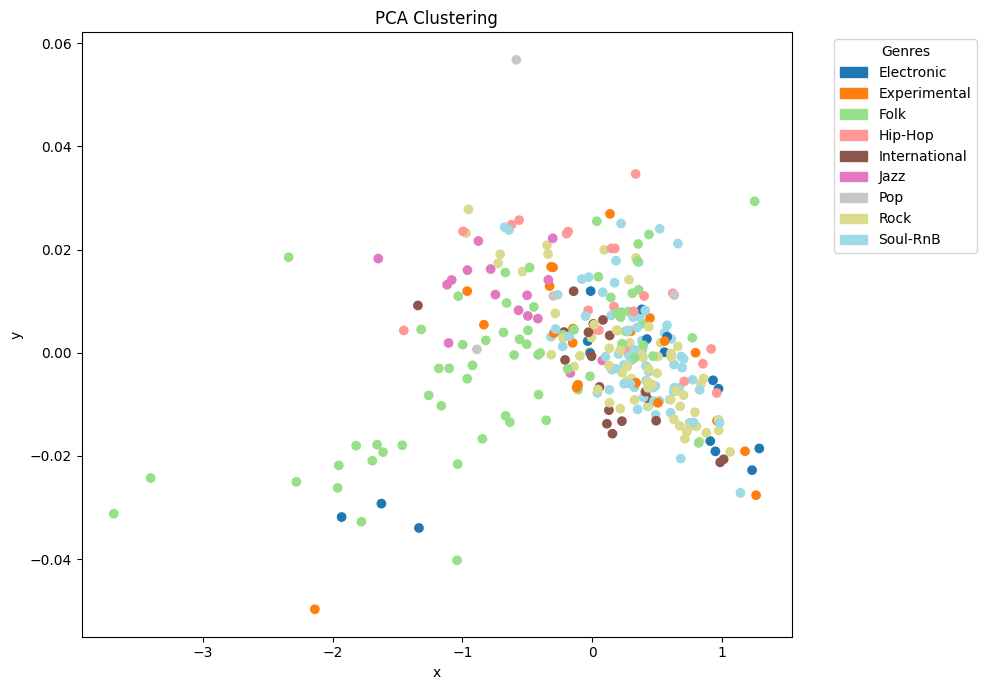

In [60]:
reduced_dim = 2
data = mu_array
genre_labels = labels
pca_clustering(data, reduced_dim, genre_labels)